In [1]:
%%writefile inference.py

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from category_encoders import CountEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt

from sklearn.multioutput import MultiOutputClassifier

import os
import warnings
warnings.filterwarnings('ignore')
import datetime
from time import time

Writing inference.py


# Framing as a binary classification problem

Original notebook: https://www.kaggle.com/fchmiel/xgboost-baseline-multilabel-classification

Baseline model using XGBoost and framing the problem as a n-binary classification problems (where n=206 and is the total number of classes). It uses [MultiOutputClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html#sklearn.multioutput.MultiOutputClassifier) wrapper in sklearn.

This has the advantages that :
- You can use models capable only of binary classification
- It is easy to implement

But has the disadvantages that:
- You lose any correlation between labels which could be useful to the model
- You need to train *n* models and is therefore slow

In [2]:
%%writefile -a inference.py

SEED = 42
NFOLDS = 5
np.random.seed(SEED)

Appending to inference.py


## Load data

In [3]:
%%writefile -a inference.py

train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
test_features = pd.read_csv('../input/lish-moa/test_features.csv')

#train_drug = pd.read_csv('../input/lish-moa/train_drug.csv')

sub = pd.read_csv('../input/lish-moa/sample_submission.csv')

Appending to inference.py


## Explore data

In [4]:
#train_features.head()

In [5]:
#train_targets.head()

In [6]:
#train_drug.head()

In [7]:
#print(f"Train_drug nr of rows: {train_drug.shape[0]}, columns: {train_drug.shape[1]}")
#print(f"Train_targets nr of rows: {train_targets.shape[0]}, columns: {train_targets.shape[1]}")
#print(f"Train_features nr of rows: {train_features.shape[0]}, columns: {train_features.shape[1]}")

In [8]:
#print(f"Counts of unique drugs in a training set:")
#print(f"{train_drug['drug_id'].value_counts()}")

In [9]:
#print(f"Number of unique drugs in a training set: {train_drug.drug_id.nunique()}")

In [10]:
# Create new Pandas df of unique drug_ids
#unique_drugs = train_drug.drug_id.unique().reshape((train_drug.drug_id.unique().size))
#unique_drugs_ids = pd.DataFrame({'drug_id' : unique_drugs[:], 'drug_index' : range(0,unique_drugs.size)})
#unique_drugs_ids

## Baseline calculation

MoA Baseline calculation is discussed here: https://www.kaggle.com/carlmcbrideellis/moa-baseline-0-02398-0-s-0-13073

The very first thing one should do in any competition is produce a baseline score against which one can measure the performance of our model. In a classification problem a good baseline to start from is to calculate the score produced what is known as the Zero Rule classifier (aka. ZeroR or 0-R), and it simply consists of the majority class (majority vote?) (i.e. the mode) of the dataset. For example in this case hypothesizing that there is no positive response to anything.

Following code:

In [11]:
#sample = pd.read_csv('../input/lish-moa/sample_submission.csv') 
#sample.iloc[:,1:] = 0.0
#sample.to_csv('submission.csv',index=False)

Produces a Public Score of:
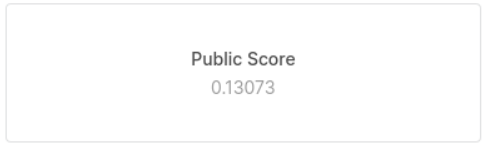

However, in this particular competition we are asked to predict probabilities, and not classes.

According to a book "Deep Learning with Python" (by Francois Chollet): 

[Baseline] ...the highest score you can reach without looking at the test features (or validation features in this case). Let's use the positivity rate of each target as measured in the training subset to generate predictions for the validation subset.

With the following code from: https://www.kaggle.com/fchollet/moa-keras-kerastuner-best-practices we get another baseline Public score, which our models need to beat.

In [12]:
# read in 
#scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
#sample = pd.read_csv('../input/lish-moa/sample_submission.csv')

# calculate
#predictions = []
#for target_name in list(scored)[1:]:
#    rate = float(sum(scored[target_name])) / len(scored)
#    predictions.append(rate)
#predictions = np.array( [predictions] * len(sample) )

# write out
#sample.iloc[:,1:] = predictions
#sample.to_csv('submission.csv',index=False)

Which gives a baseline of:
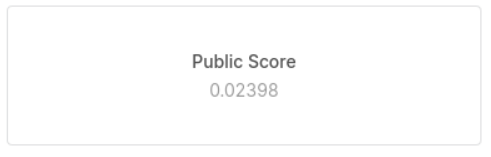

Our objective in this competition to develop a model that results in a score that is **lower** than this value (but without overfitting!)

## Preprocess data

In [13]:
%%writefile -a inference.py

def preprocess_features(df):
    df = df.copy()
    
    df['cp_dose'] = df['cp_dose'].map({'D1': 0, 'D2': 1})
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 1, 72: 2})
    #df['cp_type'] = df['cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    #df.drop(columns=['sig_id', 'cp_type'], inplace=True)
    df.drop(columns=['sig_id'], inplace=True)
    return df
    
# merge drug_id with unique index
#train_drug = train_drug.merge(unique_drugs_ids, on = 'drug_id', how = 'left')
    
# add drug_id to train_features and train_targets
#train_features = train_features.merge(train_drug, on = 'sig_id', how = 'left')
#train_features.drop(columns=['drug_id'], inplace=True)
#train_targets = train_targets.merge(train_drug, on = 'sig_id', how = 'left')
#train_targets.drop(columns=['drug_id'], inplace=True)

# preprocess train_features
train_features = preprocess_features(train_features)
train_features2 = train_features.copy() #keep train_features with cp_type to later evalute model
train_features.drop(columns=['cp_type'], inplace=True)

# preprocess test_features
test_features = preprocess_features(test_features)
test_features.drop(columns=['cp_type'], inplace=True)

# preprocess train_targets
train_targets.drop(columns=['sig_id'], inplace=True)

# transform to numpy
X_train_features = train_features.iloc[:,:].to_numpy()
y_train_targets = train_targets.iloc[:,:].to_numpy()
X_test = test_features.iloc[:,:].to_numpy()

Appending to inference.py


## Set parameters

In [14]:
%%writefile -a inference.py

classifier = MultiOutputClassifier(XGBClassifier(tree_method='gpu_hist'))

clf = Pipeline([('encode', CountEncoder(cols=[0, 2])),
                ('classify', classifier)
               ])

Appending to inference.py


In [15]:
%%writefile -a inference.py

params = {'classify__estimator__colsample_bytree': 0.6522,
          'classify__estimator__gamma': 3.6975,
          'classify__estimator__learning_rate': 0.0503,
          'classify__estimator__max_delta_step': 2.0706,
          'classify__estimator__max_depth': 10,
          'classify__estimator__min_child_weight': 31.5800,
          'classify__estimator__n_estimators': 166,
          'classify__estimator__subsample': 0.8639
         }

_ = clf.set_params(**params)

Appending to inference.py



## Train the model

Framing this problem as a binary classification problem has the disadvantage that you need to train as many models as you have classes. For this problem this means training 206 models per fold, for the large number of features included in this dataset this may take a long time...

In [16]:
%%writefile -a inference.py

oof_preds = np.zeros(y_train_targets.shape)
test_preds = np.zeros((test_features.shape[0], y_train_targets.shape[1]))
oof_losses = []
kf = KFold(n_splits=NFOLDS)

start_time = time()

for fn, (trn_idx, val_idx) in enumerate(kf.split(X_train_features, y_train_targets)):
    print('Starting fold: ', fn)
    X_train, X_val = X_train_features[trn_idx], X_train_features[val_idx]
    y_train, y_val = y_train_targets[trn_idx], y_train_targets[val_idx]
    
    # drop where cp_type==ctl_vehicle (baseline)
    #ctl_mask = X_train[:,0]=='ctl_vehicle'
    #X_train = X_train[~ctl_mask,:]
    #y_train = y_train[~ctl_mask]
    
    clf.fit(X_train, y_train)
    val_preds = clf.predict_proba(X_val) # list of preds per class
    val_preds = np.array(val_preds)[:,:,1].T # take the positive class
    oof_preds[val_idx] = val_preds
    
    loss = log_loss(np.ravel(y_val), np.ravel(val_preds))
    oof_losses.append(loss)
    preds = clf.predict_proba(X_test)
    preds = np.array(preds)[:,:,1].T # take the positive class
    test_preds += preds / NFOLDS
    
print(oof_losses)
print('Mean OOF loss across folds', np.mean(oof_losses))
print('STD OOF loss across folds', np.std(oof_losses))
print(f'Time: [{str(datetime.timedelta(seconds = time() - start_time))}]')

Appending to inference.py


In [17]:
%%writefile -a inference.py

# set control train preds to 0
control_mask = train_features2['cp_type']=='ctl_vehicle'
oof_preds[control_mask] = 0

print('OOF log loss: ', log_loss(np.ravel(y_train_targets), np.ravel(oof_preds)))
np.save('xgboos-oof.npy', oof_preds)

Appending to inference.py


## Analysis of OOF preds


In [18]:
%%writefile -a inference.py

# create the submission file
sub.iloc[:,1:] = test_preds
sub.to_csv('submission.csv', index=False)

Appending to inference.py


## Saving model

In [19]:
%%writefile -a inference.py

import joblib
# save the model to disk
filename = 'xgboost_final_model.sav'
joblib.dump(clf, filename)

Appending to inference.py


In [20]:
! python inference.py

Starting fold:  0
Starting fold:  1
Starting fold:  2
Starting fold:  3
Starting fold:  4
[0.016866573245056624, 0.016939743142604533, 0.01678390398210714, 0.01693455750032279, 0.0171170575506215]
Mean OOF loss across folds 0.01692836708414252
STD OOF loss across folds 0.00010996353440784766
Time: [0:27:03.088036]
OOF log loss:  0.016686917384286584
